In [ ]:

import torch
import torch.nn as nn
from torchinfo import summary

In [ ]:

class BasicBlock(nn.Module):

    expansion = 1

 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
      
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
      
        self.bn1 = nn.BatchNorm2d(planes)
      
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False)
      
        self.bn2 = nn.BatchNorm2d(planes)
      
        self.downsample = downsample
      
        self.stride = stride

   
    def forward(self, x):
      
        identity = x

       
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

      
        out = self.conv2(out)
        out = self.bn2(out)

        
        if self.downsample is not None:
            identity = self.downsample(x)

       
        out += identity
        out = self.relu(out)

       
        return out

In [ ]:

class Bottleneck(nn.Module):
    
    expansion = 4

    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(planes)
        
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        
        self.bn3 = nn.BatchNorm2d(planes * 4)
       
        self.relu = nn.ReLU(inplace=True)
        
        self.downsample = downsample
       
        self.stride = stride

    
    def forward(self, x):
        
        identity = x

        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        
        out = self.conv3(out)
        out = self.bn3(out)

       
        if self.downsample is not None:
            identity = self.downsample(x)

        
        out += identity
        out = self.relu(out)

       
        return out

In [ ]:

class ResNet(nn.Module):

    
    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
       
        self.bn1 = nn.BatchNorm2d(64)
       
        self.relu = nn.ReLU(inplace=True)
       
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
       
        self.inplanes = 64
       
        self.layer1 = self._make_layer(block, 64, layers[0])
      
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
      
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)

        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
       
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(512 * block.expansion, num_classes)

    
    def _make_layer(self, block, planes, blocks, stride=1):
       
        downsample = None
        
        if stride != 1 or self.inplanes != planes * block.expansion:
           
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

      
        layers = []
        
        layers.append(block(self.inplanes, planes, stride, downsample))
       
        self.inplanes = planes * block.expansion
       
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

       
        return nn.Sequential(*layers)

   
    def forward(self, x):
       
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

       
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

      
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

       
        return x

In [21]:
# 封装函数对应5个模型，num_classes表示类别数
# 其中数值与网络结构表格中的数值完全一致，可参考论文结构表
def resnet18(num_classes=1000):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

def resnet34(num_classes=1000):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes)

def resnet50(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes)

def resnet101(num_classes=1000):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes)

def resnet152(num_classes=1000):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=num_classes)

In [ ]:

summary(resnet34(), input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

Epoch: 0 Loss: 1.995849460816342 Acc: 0.03333333333333333
Epoch: 10 Loss: 1.7961381061665602 Acc: 0.2696078431372549
Epoch: 20 Loss: 1.72252576710111 Acc: 0.31862745098039214
Epoch: 30 Loss: 1.7085956446011055 Acc: 0.3509803921568627
Epoch: 40 Loss: 1.64125976624422 Acc: 0.3872549019607843
Epoch: 50 Loss: 1.5998937796269572 Acc: 0.42058823529411765
Epoch: 60 Loss: 1.5837646908618428 Acc: 0.4627450980392157
Epoch: 70 Loss: 1.564280678219948 Acc: 0.42745098039215684
Epoch: 80 Loss: 1.5515084733469786 Acc: 0.46568627450980393
Epoch: 90 Loss: 1.4594401262936534 Acc: 0.5009803921568627
Epoch: 100 Loss: 1.465150013729178 Acc: 0.557843137254902
Epoch: 110 Loss: 1.5122893928461563 Acc: 0.5637254901960784
Epoch: 120 Loss: 1.3891936367265258 Acc: 0.5686274509803921
Epoch: 130 Loss: 1.3553612413138512 Acc: 0.5784313725490197
Epoch: 140 Loss: 1.3916644895245303 Acc: 0.5774509803921568
Epoch: 150 Loss: 1.2876592037564185 Acc: 0.6098039215686275
Epoch: 160 Loss: 1.3499803542311504 Acc: 0.58627450980

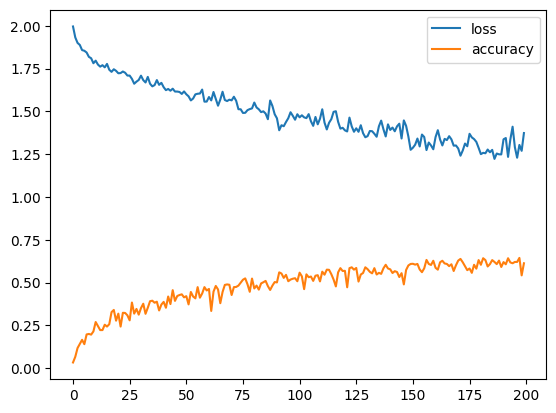

Accuracy: 0.6127450980392157


In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import *
import numpy as np
import sys


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


torch.manual_seed(0)

model = resnet18(num_classes=102).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.008, momentum=0.9)
criterion = nn.CrossEntropyLoss()


trainform_train = transforms.Compose([
    transforms.RandomRotation(30), 
    transforms.RandomResizedCrop((224, 224)), 
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5), 
    transforms.ToTensor(), 

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(), 
  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.Flowers102(root='../data/flowers102', split="test", download=True, transform=trainform_train)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)

test_dataset = datasets.Flowers102(root='../data/flowers102', split="train", download=True, transform=transform_test)

test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)


num_epochs = 200  
loss_history = [] 
acc_history = []  


for epoch in tqdm(range(num_epochs), file=sys.stdout):

    total_loss = 0
    total_correct = 0
    

    model.train()
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        total_loss += loss.item()
    

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)
            

            outputs = model(inputs)

            total_correct += (outputs.argmax(1) == labels).sum().item()
        

    loss_history.append(np.log10(total_loss)) 
    acc_history.append(total_correct / len(test_dataset))

    if epoch % 10 == 0:
        tqdm.write("Epoch: {0} Loss: {1} Acc: {2}".format(epoch, loss_history[-1], acc_history[-1]))

import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='accuracy')
plt.legend()
plt.show()

print("Accuracy:", acc_history[-1])